# Machine learning in Spark
![bbc logo](https://www.nwcu.police.uk/wp-content/uploads/2013/05/BBC-News.png)

Section influenced by [this analysis of twitter data](https://wesslen.github.io/twitter/predicting_twitter_profile_location_with_pyspark/)

## Greg's life is full of pain

Greg has become really tired of his boss asking him to do all these random things.<br>
**First** she had him learn Object Oriented Programming and it's been down hill ever since.<br>
**Now** she's wanting him to send her a summary of political news from the BBC each day.<br>
The problem is it takes him hours just to sort through the BBC website to get *just* the political articles that interest her.

## But wait!
What if rather than sorting through them himself he could build a classification model that will sort only the ones he needs?

### Create spark context

In [1]:
# !pip3 install findspark
#!pip install pyspark

In [1]:
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
spark

In [3]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

### Read in our dataset of articles

In [4]:
bbc = spark.read.csv(path='data/bbc-text.csv',sep=',',encoding='UTF-8', header=True,inferSchema=True)

In [5]:
def show(df, n=5):
    return df.limit(n).toPandas()

### Do some basic data exploration

In [6]:
bbc.columns

['category', 'text']

In [7]:
bbc.dtypes

[('category', 'string'), ('text', 'string')]

In [8]:
bbc.printSchema()

root
 |-- category: string (nullable = true)
 |-- text: string (nullable = true)



In [9]:
bbc.limit(10).toPandas()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [10]:
bbc.count()

2225

In [11]:
bbc.groupBy('category').count().show()

+-------------+-----+
|     category|count|
+-------------+-----+
|        sport|  511|
|     politics|  417|
|entertainment|  386|
|     business|  510|
|         tech|  401|
+-------------+-----+



In [12]:
# Create a new column of target "politics"
from pyspark.sql.functions import when, col
bbc = bbc.withColumn("label",
                     (when(col("category").like("%politics%"), 1)
                      .otherwise(0)))

In [13]:
# drop original target column
bbc = bbc.drop(bbc.category)

In [14]:
show(bbc,10)

,text,label
0,tv future in the hands of viewers with home th...,0
1,worldcom boss left books alone former worldc...,0
2,tigers wary of farrell gamble leicester say ...,0
3,yeading face newcastle in fa cup premiership s...,0
4,ocean s twelve raids box office ocean s twelve...,0
5,howard hits back at mongrel jibe michael howar...,1
6,blair prepares to name poll date tony blair is...,1
7,henman hopes ended in dubai third seed tim hen...,0
8,wilkinson fit to face edinburgh england captai...,0
9,last star wars not for children the sixth an...,0


## Machine Learning in Spark

Spark's [documentation](https://spark.apache.org/docs/2.2.0/ml-guide.html#mllib-main-guide) is fairly straight forward!  Let's take a look. It shouldn't look *too* different than `sklearn`

### Data prep pipeline

In [15]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer


# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# stop words
add_stopwords = ["http","https","amp","rt","t","c","can"] # standard stop words
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)


In [16]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(bbc)
dataset = pipelineFit.transform(bbc)

In [17]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 1561
Test Dataset Count: 664


### Logistic Regression

In [18]:
from pyspark.ml.classification import LogisticRegression
# Build the model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, family = "binomial")

# Train model with Training Data
lrModel = lr.fit(trainingData)

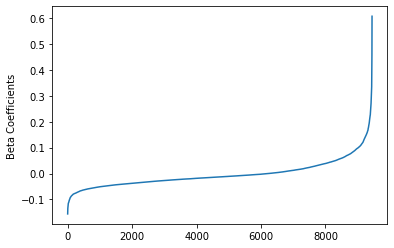

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

### Summary has many components one can call

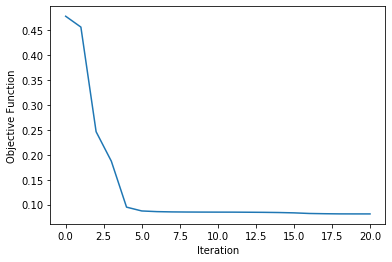

In [20]:
# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

In [21]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

trainingSummary.roc.show(n=10, truncate=15)
# roc = trainingSummary.roc.toPandas()
# plt.plot(roc['FPR'], roc['TPR'])
# plt.ylabel('False Positive Rate')
# plt.xlabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()

areaUnderROC: 0.9999318102470105
+---+---------------+
|FPR|            TPR|
+---+---------------+
|0.0|            0.0|
|0.0|0.0555555555...|
|0.0|0.1111111111...|
|0.0|0.1666666666...|
|0.0|        0.21875|
|0.0|0.2708333333...|
|0.0|0.3229166666...|
|0.0|          0.375|
|0.0|0.4305555555...|
|0.0|0.4861111111...|
+---+---------------+
only showing top 10 rows



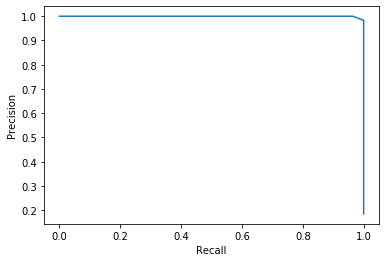

In [22]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

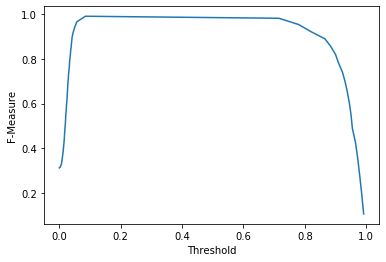

In [23]:
# Set the model threshold to maximize F-Measure
#trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

### Evaluate on test data

In [24]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)

predictions.select("text","probability").show(n=10, truncate=40)

+----------------------------------------+----------------------------------------+
|                                    text|                             probability|
+----------------------------------------+----------------------------------------+
|2d metal slug offers retro fun like s...|[0.9804110787644088,0.019588921235591...|
|a year to remember for irish there us...|[0.9971249956337924,0.002875004366207...|
|a-listers flock to gervais sitcom hol...|[0.9802504324750114,0.019749567524988...|
|aaliyah claim dismissed by court late...|[0.9607748047895676,0.039225195210432...|
|actress roberts takes spider role act...|[0.9728119265594252,0.027188073440574...|
|adventure tale tops awards young book...|[0.9765669471450196,0.02343305285498057]|
|african double in edinburgh world 500...|[0.9705370095883613,0.029462990411638...|
|aids and climate top davos agenda cli...| [0.4551814729453956,0.5448185270546043]|
|ajax refuse to rule out jol move ajax...|[0.9810804181561628,0.018919581843

#### Prediction object is a dataframe
with some options

In [25]:
predictions.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [26]:
predictions.filter(predictions['prediction'] == 1) \
    .select("text", "probability", "label", "prediction") \
    .orderBy("probability", ascending=False) \
    .show(n=20, truncate=30)

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|uk youth  interested  in po...|[0.49201168647571,0.5079883...|    1|       1.0|
|nuclear dumpsite  plan atta...|[0.4873060249997719,0.51269...|    1|       1.0|
|end bush  denial  blair tel...|[0.4699202484721028,0.53007...|    1|       1.0|
|tory  stalking horse  meyer...|[0.4675499884893324,0.53245...|    1|       1.0|
|labour trio  had vote-rig f...|[0.466123733286589,0.533876...|    1|       1.0|
|aids and climate top davos ...|[0.4551814729453956,0.54481...|    0|       1.0|
|games enter the classroom v...|[0.451182251720878,0.548817...|    0|       1.0|
|uk  needs true immigration ...|[0.4504281900970625,0.54957...|    1|       1.0|
|few ready  for information ...|[0.4438001630983848,0.55619...|    1|       1.0|
|kennedy predicts bigger tur

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training: Area Under ROC: 0.9999318102470105
Test: Area Under ROC: 0.9947692530609288


### Naive Bayes
#### Specify and fit the model

In [28]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1, modelType="multinomial")

# train the model
model = nb.fit(trainingData)

#### Evaluate Naive Bayes

As with the regression problem above, now evaluate the classifier.

In [29]:
# select example rows to display.
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 1) \
    .select("text", "probability", "label", "prediction") \
    .orderBy("probability", ascending=False) \
    .show(n=20, truncate=30)

# compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions,
                                                        {evaluator.metricName: "areaUnderROC"})))

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|world leaders gather to fac...|[0.3234856203600564,0.67651...|    0|       1.0|
|uganda bans vagina monologu...|[0.08546930870003139,0.9145...|    0|       1.0|
|pension hitch for long-livi...|[0.07509543148569661,0.9249...|    0|       1.0|
|sa unveils  more for all  b...|[0.0028957497589554115,0.99...|    0|       1.0|
|parents face video game les...|[0.002311431605911251,0.997...|    0|       1.0|
|cuba winds back economic cl...|[8.61739026907016E-5,0.9999...|    0|       1.0|
|uk helps raped rwandan wome...|[2.5209046203289186E-5,0.99...|    1|       1.0|
|eu aiming to fuel developme...|[1.5309069683180838E-5,0.99...|    0|       1.0|
|mp attacked by muggers in k...|[6.8491185912420155E-6,0.99...|    1|       1.0|
|bush to outline  toughest  

### Decision Tree


Using the `DecisionTreeClassifier` imported below, instantiate and fit a classifier with a depth of 3 to the training data.

In [30]:
from pyspark.ml.classification import DecisionTreeClassifier

Great! With a instantiated decision tree model, you can also check the number of nodes and depth of the classifier:

In [31]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3)

# Train model with Training Data
dtModel = dt.fit(trainingData)

In [32]:
print("numNodes = ", dtModel.numNodes)
print( "depth = ", dtModel.depth)

numNodes =  13
depth =  3


#### Evaluate Decision Tree

Now, evaluate the decision tree classifier you just fit.

In [33]:
predictions = dtModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("text", "probability", "label", "prediction") \
    .orderBy("probability", ascending=False) \
    .show(n=10, truncate=30)

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|custody death rate  shocks ...|                     [1.0,0.0]|    1|       0.0|
|car giant hit by mercedes s...|[0.9397865853658537,0.06021...|    0|       0.0|
|download chart debut is del...|[0.9397865853658537,0.06021...|    0|       0.0|
|cabs collect mountain of mo...|[0.9397865853658537,0.06021...|    0|       0.0|
|apple sues to stop product ...|[0.9397865853658537,0.06021...|    0|       0.0|
|camera phones are  must-hav...|[0.9397865853658537,0.06021...|    0|       0.0|
|bank voted 8-1 for no rate ...|[0.9397865853658537,0.06021...|    0|       0.0|
|camera phones are  must-hav...|[0.9397865853658537,0.06021...|    0|       0.0|
|battered dollar hits anothe...|[0.9397865853658537,0.06021...|    0|       0.0|
|campbell rescues arsenal so

In [34]:
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.615598058393103


### Random Forest


Let's try one more example. Fit a `RandomForestClassifier` with 100 trees. Each tree should have a maxDepth of 4.

In [35]:
from pyspark.ml.classification import RandomForestClassifier

In [36]:
# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=100,
                            maxDepth=4,
                            maxBins=32)

# Train model with Training Data
rfModel = rf.fit(trainingData)

#### Score and evaluate Random Forest

Evaluate the model, as you have with the other models.

In [37]:
# Score test Data
predictions = rfModel.transform(testData)

predictions.filter(predictions['prediction'] == 1) \
    .select("text", "probability", "label", "prediction") \
    .orderBy("probability", ascending=False) \
    .show(n=10, truncate=30)

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|ukip s secret weapon  by an...|[0.499793699550458,0.500206...|    1|       1.0|
|guantanamo four free in wee...|[0.4988278454999671,0.50117...|    1|       1.0|
|immigration to be election ...|[0.49215067066230556,0.5078...|    1|       1.0|
|howard attacks  pay later  ...|[0.49182422502119194,0.5081...|    1|       1.0|
|taxes must be trusted - ken...|[0.48858523521255326,0.5114...|    1|       1.0|
|women mps reveal sexist tau...|[0.48304691790979964,0.5169...|    1|       1.0|
|hague  given up  his pm amb...|[0.4817640799335666,0.51823...|    1|       1.0|
|howard unveils tory asylum ...|[0.4809234878859601,0.51907...|    1|       1.0|
|terror suspects face house ...|[0.4742786975542269,0.52572...|    1|       1.0|
|kennedy s cautious optimism

In [38]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.9852061146127653


### Implementing grid search with `CrossValidator` in pyspark

In [39]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 200])  # number of trees
             .addGrid(rf.maxDepth, [3, 4, 5])  # maximum depth
             # .addGrid(rf.maxBins, [24, 32, 40]) #Number of bins
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions,
                                                        {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.9896254437441135


## Which model had the best AUC?

### Learning goals in review. How did we do?
- align the relationships between Hadoop, Spark, and Databricks
- differentiate between Spark RDDs and Spark Dataframes and when each is appropriate
- locate and explore the Spark.ML documentation
- code along a text classification problem using four different ml algorithms, a data prep pipeline, and gridsearch to fine tune a model